In [39]:
# Extractive QA : 책에서 답을 찾는다
# 각 단어가 답의 시작일 확률 계산 start_logits
# 각 단어가 답의 끝일 확률 계산   end_logits
# 가장 확률이 높은 구간 선택      argmax

# Extractive QA 시각화
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import matplotlib.pyplot as plt
import numpy as np

In [40]:
# 모델 로드
MODEL_NAME = 'distilbert-base-cased-distilled-squad'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)

In [41]:
question = "What is the capital of France?"
# question = "What is the population of France?"
context = "Paris is the capital and largest city of France. The city has a population of 2.1 million."

In [42]:
# tokenization
inputs = tokenizer(question, context, return_tensors='pt')

In [43]:
tokenizer.decode(inputs['input_ids'][0])

'[CLS] What is the capital of Korea? [SEP] Paris is the capital and largest city of France. The city has a population of 2. 1 million. [SEP]'

In [44]:
# 예측
with torch.no_grad():
    outputs = model(**inputs)
outputs
# 토큰 리스트
tokens = tokenizer.convert_ids_to_tokens( inputs['input_ids'][0])
tokens[:10]

['[CLS]', 'What', 'is', 'the', 'capital', 'of', 'Korea', '?', '[SEP]', 'Paris']

In [45]:
# logits를 확률로 변환
start_probs = torch.softmax(outputs.start_logits, dim=-1)[0].numpy()
end_probs = torch.softmax(outputs.end_logits, dim=-1)[0].numpy()
# 답변 추출(인덱스 추출) -> 생성하는게 아니라 답변과 가장 유사한 문맥을 찾아주는 것
answer_start = np.argmax(start_probs)
answer_end = np.argmax(end_probs) + 1
answer_tokens = tokens[answer_start:answer_end]
answer = tokenizer.convert_tokens_to_string(answer_tokens)

print(f'모델의 답변 : {answer}')
print(f'시작 위치 : {answer_start}, 토큰 : {tokens[answer_start]}')
print(f'종료 위치 : {answer_end}, 토큰 : {tokens[answer_end - 1]}')
print(f'신뢰도 : {start_probs[answer_start] * end_probs[answer_end - 1]:.4f}')

모델의 답변 : Paris
시작 위치 : 9, 토큰 : Paris
종료 위치 : 10, 토큰 : Paris
신뢰도 : 0.9666


In [52]:
# 상위 5개 후보출력
# 시작위치 상위 5개
top_start = np.argsort(start_probs)[-5:][::-1]
for i, idx in enumerate(top_start):
  print(f'시작위치: {i} 토큰 : {tokens[idx]} 확률: {start_probs[idx]}')
print()
# 종료위치 상위 5개
top_end = np.argsort(end_probs)[-5:][::-1]
for i, idx in enumerate(top_end):
  print(f'종료위치: {i} 토큰 : {tokens[idx]} 확률: {end_probs[idx]}')


시작위치: 0 토큰 : Paris 확률: 0.9876977801322937
시작위치: 1 토큰 : France 확률: 0.01172531396150589
시작위치: 2 토큰 : capital 확률: 0.0001957518543349579
시작위치: 3 토큰 : The 확률: 0.00010669611947378144
시작위치: 4 토큰 : the 확률: 8.75985060702078e-05

종료위치: 0 토큰 : Paris 확률: 0.9786883592605591
종료위치: 1 토큰 : France 확률: 0.01915285363793373
종료위치: 2 토큰 : . 확률: 0.00124334916472435
종료위치: 3 토큰 : capital 확률: 0.00037561007775366306
종료위치: 4 토큰 : city 확률: 0.00011462513793958351


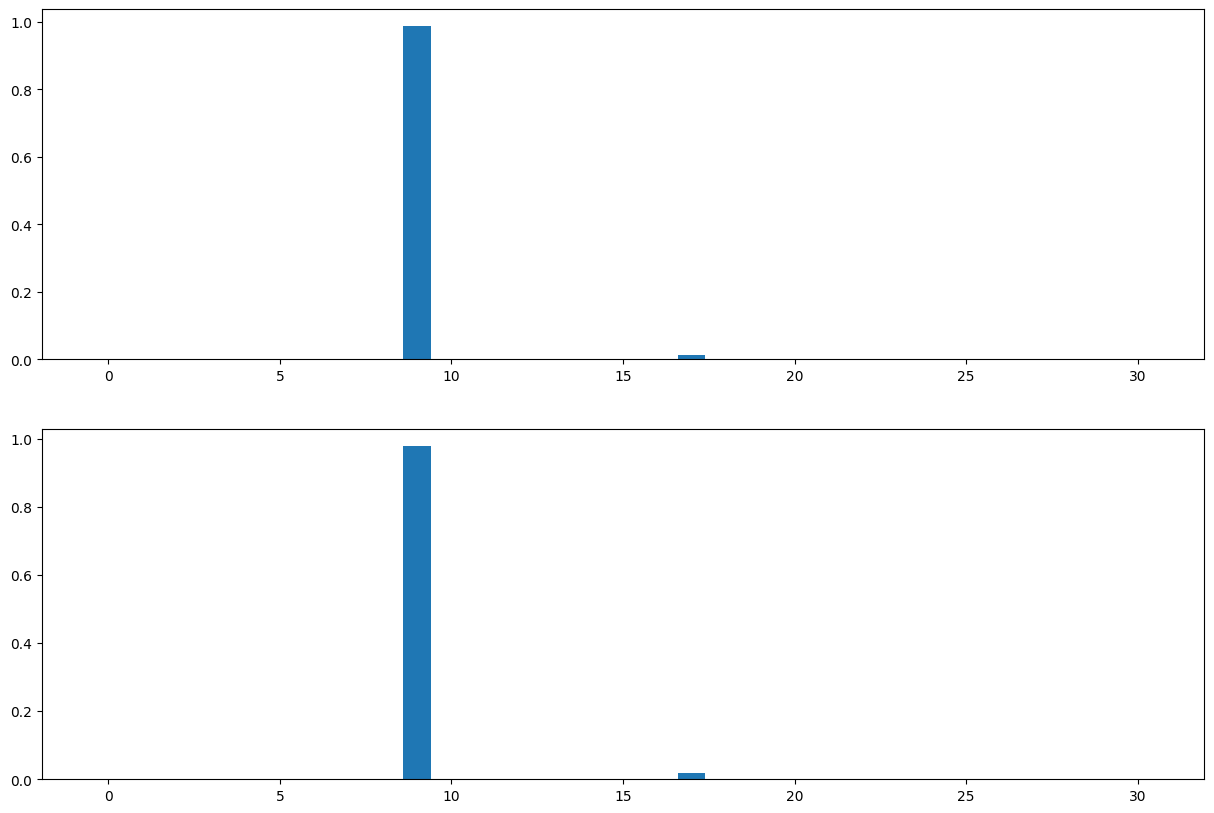

In [58]:
# 시각화
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,10))
ax1.bar(range(len(tokens)), start_probs)
ax2.bar(range(len(tokens)), end_probs)
plt.show()

In [59]:
# 결론 : 확률이 고르게 분산 -> 답을 못찾은 경우, 특정구간에 집중되면 확신있는 답을 찾음

offset mattping: 토큰단위로 찾다보면 단어가 분리되어서 자연스럽지 못하기 때문에 문자위치로 변환하는 과정을 거쳐야 자연스러운 문장이 나온다

In [60]:
"""
문맥 : Paris is the capital of France.
      012345678901234 <- 문자 인덱스
토큰 : ['Paris', 'is', 'the', 'capital', 'of', 'France', '.']
          0       1      2        3      <--- 토큰인덱스
"""

# 모델은 토큰인덱스 로 작동(3번 토큰  'capital')
# 답변위치는 문자인덱스 (13번째 문자부터 'capital' 시작)
offset_mapping = [
    (0,5), # 토큰0 : 'Paris'
    (6,8),
    (9,12),
    (13,20),
]
# 활용
# 문자위치 -> 토큰위치 : Fine-tuning시 답변 레이블 생성
# 토큰위치 -> 문자위치 : 예측 결과를 원문에 매칭

In [65]:
# 토크나이져 <-> 문자위치 변환
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
question = "What is AI?"
context = "Artificial Intelligence (AI) is the simulation of human intelligence in machines."
inputs = tokenizer(
    question,
    context,
    return_tensors='pt',
    return_offsets_mapping=True,
)
# 토큰리스트
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
offset_mapping = inputs['offset_mapping'][0].tolist()
# 전체 텍스트(질문 + 문맥)
full_text = question + context
# 토큰별 위치 매핑
print(f"{'인덱스':<8}{'토큰':<25}{'문자위치':<18}{'원문매칭'}")

인덱스     토큰                       문자위치              원문매칭


In [68]:
for idx, (token, (start, end)) in enumerate(zip(tokens, offset_mapping)):
  if start == end == 0:  # 특수 토큰
      matched_text = "[특수 토큰]"
      position = "N/A"
  else:
      # 원래 텍스트에서 추출
      matched_text = full_text[start:end]
      position = f"({start:3d}, {end:3d})"

  #답변 영역 하이라이트
  highlight = "" if "AI" in token or "Intelligence" in token else "  "
  print(f"{idx:<8} {token:<25} {position:<18} '{matched_text}' {highlight}")

0        [CLS]                     N/A                '[특수 토큰]'   
1        What                      (  0,   4)         'What'   
2        is                        (  5,   7)         'is'   
3        AI                        (  8,  10)         'AI' 
4        ?                         ( 10,  11)         '?'   
5        [SEP]                     N/A                '[특수 토큰]'   
6        Art                       (  0,   3)         'Wha'   
7        ##ific                    (  3,   7)         't is'   
8        ##ial                     (  7,  10)         ' AI'   
9        Intelligence              ( 11,  23)         'Artificial I' 
10       (                         ( 24,  25)         't'   
11       AI                        ( 25,  27)         'el' 
12       )                         ( 27,  28)         'l'   
13       is                        ( 29,  31)         'ge'   
14       the                       ( 32,  35)         'ce '   
15       simulation                ( 36,  46)       

In [76]:
# 실제 답변 위치
answer = 'Artificial Intelligence'
# 문맥에서 답변의 문자 위치 찾기
answer_start_char = context.index(answer)
answer_end_char = answer_start_char + len(answer)
# 문자위치 -> 토큰위치 변환
answer_start_token = None
answer_end_token = None
# 질문부분 건너뛰기  (seqeunce_id)
sequence_id = inputs.sequence_ids(0)
context_start_idx = sequence_id.index(1)  # 첫번째 문맥시작
# 문맥에서 절대 위치를 계산하기 위해 질문 길이 보정
question_length = len(question) + 1  # +1은 공백
abs_answer_start = answer_start_char + question_length
abs_answer_end = answer_end_char + question_length
print(f'질문 길이 보정: +(question_length)')
print(f'절대 문자 위치: {abs_answer_start} ~ {abs_answer_end}')

질문 길이 보정: +(question_length)
절대 문자 위치: 12 ~ 35


In [77]:
for idx in range(context_start_idx, len(offset_mapping)):
  start, end = offset_mapping[idx]

  if start == end == 0:  # 특수 토큰 무시
      continue

  # 답변 시작 토큰 찾기
  if answer_start_token is None and end > abs_answer_start:
      answer_start_token = idx
      print(f"    시작 토큰 발견!")
      print(f"     인덱스: {idx}")
      print(f"     토큰: '{tokens[idx]}'")
      print(f"     오프셋: ({start}, {end})")
      print()

  # 답변 종료 토큰 찾기
  if answer_end_token is None and start >= abs_answer_end:
      answer_end_token = idx - 1
      print(f"    종료 토큰 발견!")
      print(f"      인덱스: {idx - 1}")
      print(f"      토큰: '{tokens[idx-1]}'")
      print(f"      오프셋: {offset_mapping[idx-1]}")
      break

  print("\n" + "="*80)
  print("최종 결과")
  print("="*80)

  if answer_start_token and answer_end_token:
    print(f"\n 변환 성공!")
    print(f"   토큰 위치: {answer_start_token} ~ {answer_end_token}")
    print(f"   토큰 리스트: {tokens[answer_start_token:answer_end_token+1]}")

    # 역변환 확인
    reconstructed = tokenizer.convert_tokens_to_string(
        tokens[answer_start_token:answer_end_token+1]
    )
    print(f"   복원된 텍스트: '{reconstructed}'")
    print(f"   원본 텍스트: '{answer}'")

    if answer.lower() in reconstructed.lower():
        print(f"\n   검증 성공! 완벽하게 매칭됩니다.")
    else:
        print(f"\n   부분 일치 (토크나이제이션으로 인한 차이)")
  else:
   print("\n 변환 실패 - 답변을 찾을 수 없습니다")


    #  Offset Mapping이란?
    #    각 토큰이 원본 텍스트의 어느 위치에 해당하는지 기록

    #  형식:
    #    [(start_char, end_char), ...]
    #    - start_char: 토큰 시작 문자 위치
    #    - end_char: 토큰 종료 문자 위치 (exclusive)

    # 변환 방법:
    #    1. 문자 위치 → 토큰 위치
    #       - offset_mapping을 순회
    #       - 문자 위치가 offset 범위 내에 있는 토큰 찾기

    #    2. 토큰 위치 → 문자 위치
    #       - offset_mapping[토큰_인덱스] 직접 참조

    # 주의사항:
    #    - 특수 토큰은 (0, 0)으로 표시
    #    - truncation으로 잘린 부분은 offset 없음
    #    - Fine-tuning 시 필수적으로 사용!

    # 활용:
    #    - SQuAD 데이터 전처리: 답변 문자 위치 → 토큰 위치
    #    - 예측 결과 해석: 토큰 위치 → 원문 매칭
    #    - 답변 검증: 예측한 토큰이 실제 답변과 일치하는지 확인


최종 결과

 변환 실패 - 답변을 찾을 수 없습니다

최종 결과

 변환 실패 - 답변을 찾을 수 없습니다

최종 결과

 변환 실패 - 답변을 찾을 수 없습니다
    시작 토큰 발견!
     인덱스: 9
     토큰: 'Intelligence'
     오프셋: (11, 23)


최종 결과

 변환 실패 - 답변을 찾을 수 없습니다

최종 결과

 변환 실패 - 답변을 찾을 수 없습니다

최종 결과

 변환 실패 - 답변을 찾을 수 없습니다

최종 결과

 변환 실패 - 답변을 찾을 수 없습니다

최종 결과

 변환 실패 - 답변을 찾을 수 없습니다

최종 결과

 변환 실패 - 답변을 찾을 수 없습니다
    종료 토큰 발견!
      인덱스: 14
      토큰: 'the'
      오프셋: [32, 35]


In [79]:
# SQuAD 데이터 전처리
# SQuAD 모델이 이해할 수 있는 형식으로 바꾸는 과정에 대한 이해
'''
{
  'question' : 'When was ~~~?',
  'context' : 'The Eiffel Tower...',
  'answer' : {
    'text': ['1889'],
    'answer_start': [31]  <- 문자 위치
  }
}
'''
# 1. 토크나이제이션
# [CLS] When was ... [SEP] The Eiffel tower .... [SEP]

# 2. 답변 문자 위치 확인
answer_start_char = 31
answer_end_char = 35 # (31 + len('1889'))
# 3. sequence_ids로 문맥 범위 찾기
context_range = [10, 45] # 토큰 10번 ~ 45번이 문맥
# 4. offset_mapping 으로 토큰 위치 변환
answer_start_token = 18  # (토큰18번 = 1889의 시작)
answer_end_token = 19  # (토큰19번 = 1889의 끝)
# 5. 검증   답변이 문맥 내 -> yes, truncate로 잘리지 않음 -> yes
# 6. 최종 학습데이터 생성
'''
  {
    'input_ids' : ...
    'attention_mask' : ...
    'start_posiition' : ...
    'end_position' : ...
  }
'''

"\n  {\n    'input_ids' : ...\n    'attention_mask' : ...\n    'start_posiition' : ...\n    'end_position' : ...\n  }\n"

In [90]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
# SQuAD 데이터 샘플
sample = {
    "question": "When was the Eiffel Tower built?",
    "context": "The Eiffel Tower was built in 1889 for the Paris World's Fair. It was designed by Gustave Eiffel and remains one of the most iconic structures in the world.",
    "answers": {
        "text": ["1889"],
        "answer_start": [31]  # "1889"의 문자 시작 위치
    }
}

# 토크나이제이션
inputs = tokenizer(
    sample['question'],
    sample['context'],
    max_length=384,
    truncation='only_second', # 문맥만 자르기
    return_offsets_mapping=True, # 오프셋 매핑
    return_tensors='pt',
    padding='max_length' # 최대길이로 패딩
)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print(f'총 토큰수 : {len(tokens)}')
print(f'실제 : {inputs['attention_mask'][0].tolist().count(1)}')
print(f'패딩 : {inputs['attention_mask'][0].tolist().count(0)}')

총 토큰수 : 384
실제 : 49
패딩 : 335


In [99]:
# 답변 문자위치 확인
answer_text = sample['answers']['text'][0]
answer_start_char = sample['answers']['text'][0]
# answer_end_char = answer_start_char + len(answer_text)
print(f'답변 텍스트: {answer_text}')
print(f'답변 시작: {answer_start_char}')
# print(f'답변 종료: {answer_end_char}')
# print(f"검증 : {sample['context'][answer_start_char:answer_end_char]}")

답변 텍스트: 1889
답변 시작: 1889


In [102]:
# sequence_id로 문맥 범위 찾기
# token_type_id 와 유사  문장의 종류  0:질문, 1:문장, None: 특수토큰 또는 패딩
sequence_ids = inputs.sequence_ids(0)
# 문맥의 시작과 끝
context_start = sequence_ids.index(1)
context_end = sequence_ids[::-1].index(1)
print(f'특수토큰: {sequence_ids.count(None)}')
print(f'0 질문: {sequence_ids.count(0)}')
print(f'1 문맥: {sequence_ids.count(1)}')
print(f'문맥시작 : {context_start}')
print(f'문맥종료 : {context_end}')

특수토큰: 338
0 질문: 9
1 문맥: 37
문맥시작 : 11
문맥종료 : 336
